In [1]:
!nvidia-smi

Sun Jul  6 16:20:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import sys

assert sys.version_info >= (3, 7)


In [3]:
import os
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules or "KAGGLE_URL_BASE" in os.environ

if IS_COLAB or IS_KAGGLE:
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

2025-07-06 16:20:42.201098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751818842.378502      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751818842.431654      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [5]:
import tf_keras
print("Legacy Keras version:", tf_keras.__version__)


Legacy Keras version: 2.18.0


In [6]:
from pathlib import Path

In [4]:
import tensorflow as tf
shakespeare_url= "https://homl.info/shakespeare"
filepath=tf.keras.utils.get_file("shakespeare.txt",shakespeare_url)
with open(filepath) as f:
  shakespeare_text=f.read()

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [6]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [7]:
"""Use a tf.keras.layer.TextVectorization layer to encode this text """
text_vec_layer = tf.keras.layers.TextVectorization(split="character",standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded=text_vec_layer([shakespeare_text])[0]

I0000 00:00:1751648101.037985    2202 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14965 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
encoded -= 2
n_tokens= text_vec_layer.vocabulary_size()-2
dataset_size=len(encoded)

In [9]:
n_tokens

39

In [10]:
dataset_size

1115394

In [11]:
"""Now we turn this very long Sequence into a dataset of windows that we can the use to train a sequence to sequence RNN. """
def to_dataset(sequence,length,shuffle=False,seed=None,batch_size=32):
  ds=tf.data.Dataset.from_tensor_slices(sequence)
  ds=ds.window(length+1,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda window_ds: window_ds.batch(length+1))
  if shuffle:
    ds=ds.shuffle(100_000,seed=seed)
  ds=ds.batch(batch_size)
  return ds.map(lambda window: (window[:,:-1],window[:,1:])).prefetch(1)

In [12]:
"""Now we ready to create the training set, the validation set, and test set, we will use roughly 90% of text for a training , 5% for validation , and  5% for testing"""
length = 100
tf.random.set_seed(42)
train_set=to_dataset(encoded[:1_000_000],length=length,shuffle=True,seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000],length=length)
test_set=to_dataset(encoded[1_060_000:],length=length)

### Building and Training the Char-RNN Model

In [13]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens,output_dim=64),
    tf.keras.layers.GRU(512,return_sequences=True),
    tf.keras.layers.Dense(n_tokens,activation="softmax")
])

In [14]:
with tf.device('/GPU:0'):
    model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
    model_ckpt= tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_mode.h5",monitor="val_accuracy",save_best_only=True)
    history=model.fit(train_set,validation_data=valid_set,epochs=1,callbacks=[model_ckpt])

I0000 00:00:1751648128.829924    2233 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751648129.040910    2233 service.cc:148] XLA service 0x7f2b669fd8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751648129.041671    2233 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751648129.386444    2233 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

In [15]:
with tf.device('/GPU:0'):
    shakespeare_model1= tf.keras.Sequential([
        text_vec_layer,
        tf.keras.layers.Lambda(lambda X: X-2),
        model
])

In [16]:
from pathlib import Path
# extra code – downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
if "_extracted" in path:
    model_path = Path(path) / "shakespeare_model"
else:
    model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)


In [21]:
"""let's use it to predict the next character in a sentence"""
y_proba = shakespeare_model.predict(["To be or not to b"])[0,-1]
y_pred= tf.argmax(y_proba) # choose the most probable character ID
predicated_char = text_vec_layer.get_vocabulary()[y_pred+2]
print("Next  Character is: ",predicated_char)

1/1 [==============================] - 0s 35ms/step
Next  Character is:  e


### Generating Fake Shakespearean Text

In [18]:
log_probas = tf.math.log([[0.5,0.4,0.1]]) # probas =50% , 40% , 10% 
tf.random.set_seed(42)
tf.random.categorical(log_probas,num_samples=8) # draw 8 samples


<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [19]:
def next_char(text,temperature =1):
    y_proba = shakespeare_model.predict([text])[0,-1:]
    rescaled_logits = tf.math.log(y_proba)/temperature
    char_id = tf.random.categorical(rescaled_logits,num_samples=1)[0,0]
    return text_vec_layer.get_vocabulary()[char_id+2]

In [22]:
"""write another small helper function that will repeactly call next_char() to get the next character and append it to the given text:"""
def extend_text(text,n_chars=50,temperature=1):
    for _ in range(n_chars):
        text+=next_char(text,temperature)
    return text

In [23]:
tf.random.set_seed(42)
text_input = tf.constant(["to be not to be"])# extra code – downloads a pretrained model
print(extend_text(text_input,temperature =0.01)) 

1/1 [==============================] - 0s 24ms/step
tf.Tensor([b'to be not to be the duke\nas it is a proper strange death,\nand the'], shape=(1,), dtype=string)


### Stateful RNN


In [24]:
def to_dataset_for_stateful_rnn(sequence,length):
    ds= tf.data.Dataset.from_tensor_slices(sequence)
    ds= ds.window(length+1,shift=length,drop_remainder=True)
    ds=ds.flat_map(lambda window:window.batch(length+1)).batch(1)
    return ds.map(lambda window:(window[:,:-1],window[:,1:])).prefetch(1)

In [25]:
stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000],length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],length)
stateful_set_set = to_dataset_for_stateful_rnn(encoded[1_060_000:],length)

In [26]:

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,batch_input_shape=[1,None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 16)             624       
                                                                 
 gru_1 (GRU)                 (1, None, 128)            56064     
                                                                 
 dense_1 (Dense)             (1, None, 39)             5031      
                                                                 
Total params: 61719 (241.09 KB)
Trainable params: 61719 (241.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
"""Need to reset the states before we go back to the beginning of the text ,for this we use a small custom Keras callback"""
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [30]:
model_ckpt=tf.keras.callbacks.ModelCheckpoint(
    "my_Stateful_shakespeare_mode.h5",
    monitor="val_accuracy",
    save_best_only=True
)

In [31]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set,validation_data=stateful_valid_set,
                    epochs=10,callbacks=[ResetStatesCallback(),model_ckpt])

Epoch 1/10
9999/9999 [==============================] - 89s 8ms/step - loss: 1.8716 - accuracy: 0.4489 - val_loss: 1.7073 - val_accuracy: 0.4886
Epoch 2/10
  15/9999 [..............................] - ETA: 1:17 - loss: 1.7932 - accuracy: 0.4487

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9999/9999 [==============================] - 81s 8ms/step - loss: 1.5631 - accuracy: 0.5283 - val_loss: 1.6191 - val_accuracy: 0.5165
Epoch 3/10
9999/9999 [==============================] - 80s 8ms/step - loss: 1.4853 - accuracy: 0.5485 - val_loss: 1.5833 - val_accuracy: 0.5253
Epoch 4/10
9999/9999 [==============================] - 80s 8ms/step - loss: 1.4466 - accuracy: 0.5589 - val_loss: 1.5643 - val_accuracy: 0.5295
Epoch 5/10
9999/9999 [==============================] - 82s 8ms/step - loss: 1.4226 - accuracy: 0.5645 - val_loss: 1.5517 - val_accuracy: 0.5323
Epoch 6/10
9999/9999 [==============================] - 81s 8ms/step - loss: 1.4060 - accuracy: 0.5685 - val_loss: 1.5441 - val_accuracy: 0.5351
Epoch 7/10
9999/9999 [==============================] - 80s 8ms/step - loss: 1.3942 - accuracy: 0.5715 - val_loss: 1.5378 - val_accuracy: 0.5379
Epoch 8/10
9999/9999 [==============================] - 81s 8ms/step - loss: 1.3858 - accuracy: 0.5736 - val_loss: 1.5308 - val_accuracy: 0.5

In [37]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

In [42]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=2))

1/1 [==============================] - 0s 36ms/step
to be or not to best,
o dusdness or; this vens pan. bel:
th ionstent


*Extra Material: converting the stateful RNN to a stateless RNN and using it* 

In [34]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens,output_dim=16),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.Dense(n_tokens,activation="softmax")
])

In [35]:
stateless_model.build(tf.TensorShape([None,None]))


In [36]:
stateless_model.set_weights(model.get_weights())

In [39]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [43]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=1))

1/1 [==============================] - 0s 39ms/step
to be or not to best,
a duen growor; this very win. believe i not
an


### Sentiment Analysis

In [5]:
import tensorflow_datasets as tfds
raw_train_set,raw_valid_set,raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]","train[90%:]","test"],
    as_supervised=True
)


I0000 00:00:1751695551.385136   45742 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000,seed=42).batch(32).prefetch(tf.data.AUTOTUNE)
valid_set = raw_valid_set.batch(32).prefetch(tf.data.AUTOTUNE)
test_set = raw_test_set.batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
for review ,label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8"))
    print("Label",label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development 

Tokenization using textVectorization layer 

In [8]:
vocab_size= 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews,labels:reviews))

Train model 

In [49]:
embed_size=128
tf.random.set_seed(42)
model=tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size,embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [50]:
model.compile(loss="binary_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set,validation_data=valid_set,epochs=2)

Epoch 1/2
704/704 [==============================] - 63s 77ms/step - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/2
704/704 [==============================] - 34s 48ms/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4992


*Masking*

In [52]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 62s 69ms/step - loss: 0.6233 - accuracy: 0.6505 - val_loss: 0.5699 - val_accuracy: 0.7316
Epoch 2/5
704/704 [==============================] - 28s 39ms/step - loss: 0.4116 - accuracy: 0.8134 - val_loss: 0.3401 - val_accuracy: 0.8548
Epoch 3/5
704/704 [==============================] - 26s 36ms/step - loss: 0.3261 - accuracy: 0.8602 - val_loss: 0.3987 - val_accuracy: 0.8232
Epoch 4/5
704/704 [==============================] - 26s 37ms/step - loss: 0.2993 - accuracy: 0.8755 - val_loss: 0.3055 - val_accuracy: 0.8704
Epoch 5/5
704/704 [==============================] - 25s 36ms/step - loss: 0.2798 - accuracy: 0.8824 - val_loss: 0.3110 - val_accuracy: 0.8628


*manual masking*

In [53]:
inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids,0)
Z= tf.keras.layers.Embedding(vocab_size,embed_size)(token_ids)
Z=tf.keras.layers.GRU(128,dropout=0.2)(Z,mask=mask)
outputs= tf.keras.layers.Dense(1,activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])

*Ragged Tensor*

In [54]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,ragged=True
)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews,labels:reviews))
text_vec_layer_ragged(["Great movies!","This is DiCaprio's best role"])

<tf.RaggedTensor [[86, 93], [11, 7, 1, 116, 217]]>

In [ ]:
"""Their is clear difference between in ragged tensor and a regular tensor """
text_vec_layer(["Great movies!","This is DiCaprio's best role"])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  93,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

### Reusing PreTrained Embedding and Language Models

In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            trainable=True,
            dtype=tf.string,
            input_shape=[]
    ),
        tf.keras.layers.Dense(64, activation='relu'),  
        tf.keras.layers.Dense(1, activation='sigmoid')
])


I0000 00:00:1751734362.576725      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
with tf.device('/GPU:0'):
    model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
    model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


I0000 00:00:1751695619.067880   45780 service.cc:148] XLA service 0x7bc632651f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751695619.067925   45780 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751695619.091602   45780 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751695619.260064   45780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 [==============================] - 884s 1s/step - loss: 0.2900 - accuracy: 0.8777 - val_loss: 0.2341 - val_accuracy: 0.8984
Epoch 2/10
704/704 [==============================] - 171s 244ms/step - loss: 0.0246 - accuracy: 0.9930 - val_loss: 0.3074 - val_accuracy: 0.8976
Epoch 3/10
704/704 [==============================] - 113s 157ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.3654 - val_accuracy: 0.8956
Epoch 4/10
704/704 [==============================] - 95s 135ms/step - loss: 6.1220e-04 - accuracy: 1.0000 - val_loss: 0.3986 - val_accuracy: 0.9004
Epoch 5/10
704/704 [==============================] - 83s 117ms/step - loss: 4.5247e-04 - accuracy: 1.0000 - val_loss: 0.4368 - val_accuracy: 0.8992
Epoch 6/10
704/704 [==============================] - 77s 109ms/step - loss: 3.5780e-05 - accuracy: 1.0000 - val_loss: 0.4731 - val_accuracy: 0.8992
Epoch 7/10
704/704 [==============================] - 81s 115ms/step - loss: 1.6162e-05 - accuracy: 1.0000 - val_loss: 0.5023 - v

In [ ]:
texts = tf.constant(["I really enjoyed this!", "This was terrible."])
predictions = model.predict(texts)
print(predictions)

### An Encoder-Decoder Network for Neural Machine Translation 

In [7]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip",origin=url,cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng")/"spa.txt").read_text()

2638744/2638744 [==============================] - 0s 0us/step


In [8]:
import numpy as np 
text = text.replace("i","").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en ,sentences_es = zip(*pairs) # separates the pairs into 2 lists

In [9]:
for i in range(3):
    print(sentences_en[i],"=>",sentences_es[i])

How borng! => ¡Qué aburrmento!
I love sports. => Adoro el deporte.
Would you lke to swap jobs? => Te gustaría que ntercambemos los trabajos?


In [10]:
vocab_size = 1000
max_length = 50 
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size,output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size,output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

I0000 00:00:1751802745.010638      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 's', 'he']

In [12]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [13]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])


In [14]:
tf.random.set_seed(42) 
encoder_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)

In [15]:
embed_size=128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,embed_size,mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,embed_size,mask_zero=True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [16]:
encoder = tf.keras.layers.LSTM(512,return_state=True)
encoder_outputs,*encoder_state = encoder(encoder_embeddings)

In [17]:
decoder = tf.keras.layers.LSTM(512,return_sequences=True)
decoder_outputs = decoder(decoder_embeddings,initial_state=encoder_state)

In [18]:
output_layer = tf.keras.layers.Dense(vocab_size,activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [19]:
model = tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train,X_train_dec),Y_train,epochs=10,
          validation_data=((X_valid,X_valid_dec),Y_valid))

Epoch 1/10


I0000 00:00:1751802779.852842      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751802780.876670      79 service.cc:148] XLA service 0x7b405e896b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751802780.877333      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751802781.173894      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 78s 20ms/step - loss: 2.9064 - accuracy: 0.4287 - val_loss: 2.1621 - val_accuracy: 0.5231
Epoch 2/10
3125/3125 [==============================] - 48s 15ms/step - loss: 1.8459 - accuracy: 0.5755 - val_loss: 1.6571 - val_accuracy: 0.6089
Epoch 3/10
3125/3125 [==============================] - 47s 15ms/step - loss: 1.4379 - accuracy: 0.6482 - val_loss: 1.4421 - val_accuracy: 0.6505
Epoch 4/10
3125/3125 [==============================] - 48s 15ms/step - loss: 1.2074 - accuracy: 0.6935 - val_loss: 1.3390 - val_accuracy: 0.6718
Epoch 5/10
3125/3125 [==============================] - 47s 15ms/step - loss: 1.0450 - accuracy: 0.7267 - val_loss: 1.3003 - val_accuracy: 0.6800
Epoch 6/10
3125/3125 [==============================] - 47s 15ms/step - loss: 0.9125 - accuracy: 0.7553 - val_loss: 1.2901 - val_accuracy: 0.6840
Epoch 7/10
3125/3125 [==============================] - 47s 15ms/step - loss: 0.7994 - accuracy: 0.7798 - val_loss: 1.3068 - val_accura

In [20]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en]) # encoder Input
        X_dec = np.array(["startofseq "+translation]) # decoder input
        y_proba = model.predict((X,X_dec))[0,word_idx] # last token's probas
        predicated_word_id = np.argmax(y_proba)
        predicated_word = text_vec_layer_es.get_vocabulary()[predicated_word_id]
        if predicated_word =="endofseq":
            break
        translation +=" "+predicated_word
    return translation.strip()

In [21]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 19ms/step


'yo [UNK] y la [UNK] [UNK] a la playa'

### Bidirectional RNNs

*to Create a Bidirectinal recurrent layer , just wrap a regular recurrent layer in a `Bidirectional` layer:*

In [22]:
tf.random.set_seed(42)
encoder =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True,return_state=True))

In [23]:
output = encoder(encoder_embeddings)
print(type(output))
print(output)


<class 'list'>
[<KerasTensor: shape=(None, 50, 512) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'bidirectional')>]


In [24]:
encoder_outputs ,*encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2],axis=-1), #short-term (0&2)
                 tf.concat(encoder_state[1::2],axis=-1)]#long term (1&3)

In [25]:
decoder = tf.keras.layers.LSTM(512,return_sequences=True)
decoder_outputs= decoder(decoder_embeddings,initial_state=encoder_state)
output_layer=tf.keras.layers.Dense(vocab_size,activation="softmax")
Y_proba = tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],
                         outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train,X_train_dec),Y_train,epochs=10,
          validation_data=((X_valid,X_valid_dec),Y_valid))

Epoch 1/10
3125/3125 [==============================] - 77s 20ms/step - loss: 0.4884 - accuracy: 0.8552 - val_loss: 1.4662 - val_accuracy: 0.6769
Epoch 2/10
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4268 - accuracy: 0.8725 - val_loss: 1.5281 - val_accuracy: 0.6729
Epoch 3/10
3125/3125 [==============================] - 48s 15ms/step - loss: 0.3846 - accuracy: 0.8845 - val_loss: 1.5736 - val_accuracy: 0.6711
Epoch 4/10
3125/3125 [==============================] - 48s 15ms/step - loss: 0.3521 - accuracy: 0.8928 - val_loss: 1.6299 - val_accuracy: 0.6696
Epoch 5/10
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3242 - accuracy: 0.9005 - val_loss: 1.6813 - val_accuracy: 0.6671
Epoch 6/10
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3034 - accuracy: 0.9067 - val_loss: 1.7189 - val_accuracy: 0.6650
Epoch 7/10
3125/3125 [==============================] - 47s 15ms/step - loss: 0.2870 - accuracy: 0.9114 - val_loss: 1.7649 -

In [26]:
translate("I like soccer")

1/1 [==============================] - 0s 19ms/step


'me [UNK] el fútbol'

### Beam Search

**A basic implementation of beam search**

In [27]:
def beam_search(sentence_en,beam_width,verbose = False):
    X = np.array([sentence_en])
    X_dec =np.array(["startofseq"])
    y_proba = model.predict((X,X_dec))[0,0]
    top_k = tf.math.top_k(y_proba,k=beam_width)
    top_translations= [
        (np.log(word_proba),text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba,word_id in zip(top_k.values,top_k.indices)
    ]
    if verbose:
        print("Top first words: ",top_translations)
    
    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [28]:
# shows how the model making an error
sentence_en="I love cars and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 21ms/step


'me encanta el perro y la leche'

In [29]:
beam_search(sentence_en,beam_width=3,verbose=True)

1/1 [==============================] - 0s 20ms/step
Top first words:  [(-0.0335773, 'me'), (-3.8004887, '[UNK]'), (-4.5874534, 'yo')]
1/1 [==============================] - 0s 20ms/step
Top translations so far: [(-0.2919073, 'me encanta'), (-1.5930568, 'me [UNK]'), (-3.9320498, '[UNK] el')]
1/1 [==============================] - 0s 20ms/step
Top translations so far: [(-0.8305429, 'me encanta el'), (-1.8122085, 'me encanta la'), (-1.9909414, 'me encanta [UNK]')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(-1.0320903, 'me encanta el perro'), (-2.3149734, 'me encanta la comda'), (-2.6302226, 'me encanta [UNK] el')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-1.128205, 'me encanta el perro y'), (-2.3336859, 'me encanta la comda [UNK]'), (-3.134563, 'me encanta [UNK] el perro')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-1.5367595, 'me encanta el perro y la'), (-2.3357089, 'me encanta

'me encanta la comda [UNK]'

#### Attention Mechanisms


**use to get the pay on some part of input sequence**

In [30]:
attention_layer= tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs,encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size,activation="softmax")
Y_proba = output_layer(attention_outputs)

In [31]:
model = tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train,X_train_dec),Y_train,epochs=10,
          validation_data=((X_valid,X_valid_dec),Y_valid))

Epoch 1/10


W0000 00:00:1751803845.723487      35 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16266690560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3122/3125 [============================>.] - ETA: 0s - loss: 2.1942 - accuracy: 0.5400

W0000 00:00:1751803918.163562      35 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16266690560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3125/3125 [==============================] - 92s 24ms/step - loss: 2.1935 - accuracy: 0.5401 - val_loss: 1.4954 - val_accuracy: 0.6413
Epoch 2/10
3125/3125 [==============================] - 55s 18ms/step - loss: 1.3464 - accuracy: 0.6728 - val_loss: 1.3170 - val_accuracy: 0.6812
Epoch 3/10
3125/3125 [==============================] - 55s 18ms/step - loss: 1.1655 - accuracy: 0.7095 - val_loss: 1.2467 - val_accuracy: 0.6976
Epoch 4/10
3125/3125 [==============================] - 55s 18ms/step - loss: 1.0407 - accuracy: 0.7350 - val_loss: 1.2185 - val_accuracy: 0.7056
Epoch 5/10
3125/3125 [==============================] - 55s 18ms/step - loss: 0.9409 - accuracy: 0.7560 - val_loss: 1.2134 - val_accuracy: 0.7087
Epoch 6/10
3125/3125 [==============================] - 55s 18ms/step - loss: 0.8579 - accuracy: 0.7732 - val_loss: 1.2336 - val_accuracy: 0.7073
Epoch 7/10
3125/3125 [==============================] - 56s 18ms/step - loss: 0.7891 - accuracy: 0.7882 - val_loss: 1.2542 - val_accura

In [32]:
translate("I like soccer and also going to the beach")

W0000 00:00:1751804427.348231      35 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16266690560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 20ms/step


'[UNK] [UNK] de fútbol y [UNK] tambén a la playa'

In [33]:
beam_search("I like soccer and also going to the beach",beam_width=3,verbose=True)

1/1 [==============================] - 0s 21ms/step
Top first words:  [(-0.48540512, '[UNK]'), (-1.7206956, 'yo'), (-2.8638213, 'v')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-1.553843, '[UNK] [UNK]'), (-1.8843007, '[UNK] el'), (-2.273538, 'yo [UNK]')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-1.8979176, '[UNK] el fútbol'), (-1.903278, '[UNK] [UNK] de'), (-2.3336494, 'yo [UNK] fútbol')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-1.935224, '[UNK] [UNK] de fútbol'), (-2.363721, '[UNK] el fútbol y'), (-2.4898522, 'yo [UNK] fútbol y')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(-2.0270689, '[UNK] [UNK] de fútbol y'), (-2.7247365, 'yo [UNK] fútbol y tambén'), (-3.0981936, '[UNK] el fútbol y tambén')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(-2.443846, '[UNK] [UNK] de fútbol y [UNK]'), (-2.7547545, 'yo [UNK]

'[UNK] [UNK] de fútbol y [UNK] tambén a la playa'

*Postional Encodings*

In [34]:
max_length = 50 
embed_size=128

tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length,embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in= encoder_embeddings+pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in= decoder_embeddings+pos_embed_layer(tf.range(batch_max_len_dec))

In [36]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [37]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)


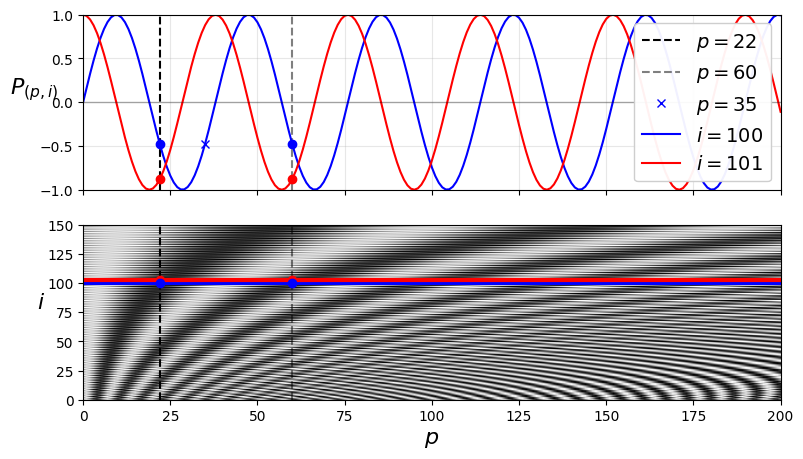

In [40]:
# extra code – this cells generates and saves Figure 16–9
import matplotlib.pyplot as plt
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)

plt.show()

#### Multi - Head Attention

In [41]:
N=2
num_heads=8
dropout_rate=0.1
n_units = 128
encoder_pad_mask = tf.math.not_equal(encoder_input_ids,0)[:,tf.newaxis]
Z= encoder_in
for _ in range(N):
    skip = Z 
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=embed_size,dropout=dropout_rate
    )
    Z = attn_layer(Z,value=Z,attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z,skip]))
    skip=Z
    Z=tf.keras.layers.Dense(n_units,activation="relu")(Z)
    Z=tf.keras.layers.Dense(embed_size)(Z)
    Z=tf.keras.layers.Dropout(dropout_rate)(Z)
    Z=tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z,skip]))


In [42]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids,0)[:,tf.newaxis]
casual_mask= tf.linalg.band_part( # creates a lower triagular matrix
    tf.ones((batch_max_len_dec,batch_max_len_dec),tf.bool),-1,0
)

In [43]:
encoder_outputs=Z
Z= decoder_in
for _ in range(N):
    skip=Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=embed_size,dropout=dropout_rate
    )
    Z = attn_layer(Z,value=Z,attention_mask=casual_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z,skip]))
    skip=Z
    
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [45]:
Y_proba = tf.keras.layers.Dense(vocab_size,activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train,X_train_dec),Y_train,epochs=10,
          validation_data=((X_valid,X_valid_dec),Y_valid))

Epoch 1/10
3125/3125 [==============================] - 172s 46ms/step - loss: 1.8734 - accuracy: 0.5931 - val_loss: 1.4124 - val_accuracy: 0.6638
Epoch 2/10
3125/3125 [==============================] - 128s 41ms/step - loss: 1.3677 - accuracy: 0.6687 - val_loss: 1.2981 - val_accuracy: 0.6833
Epoch 3/10
3125/3125 [==============================] - 128s 41ms/step - loss: 1.2659 - accuracy: 0.6880 - val_loss: 1.2452 - val_accuracy: 0.6972
Epoch 4/10
3125/3125 [==============================] - 127s 41ms/step - loss: 1.2047 - accuracy: 0.6994 - val_loss: 1.1893 - val_accuracy: 0.7047
Epoch 5/10
3125/3125 [==============================] - 127s 41ms/step - loss: 1.1587 - accuracy: 0.7078 - val_loss: 1.1999 - val_accuracy: 0.7037
Epoch 6/10
3125/3125 [==============================] - 127s 41ms/step - loss: 1.1227 - accuracy: 0.7140 - val_loss: 1.1383 - val_accuracy: 0.7163
Epoch 7/10
3125/3125 [==============================] - 127s 41ms/step - loss: 1.0929 - accuracy: 0.7202 - val_loss: 1

In [46]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 24ms/step


'[UNK] fútbol y yo tambén [UNK] a la playa'

### HuggingFace

In [7]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

result = classifier("The actors were very convincing")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [8]:
result

[{'label': 'POSITIVE', 'score': 0.9998143315315247}]

In [12]:
classifier(["I am from India","i am from iraq"])

[{'label': 'POSITIVE', 'score': 0.9907897710800171},
 {'label': 'NEGATIVE', 'score': 0.9706069231033325}]

In [13]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"

classifier_mnli = pipeline("text-classification",model = model_name)
classifier_mnli("she loves me.[SEP] She loves me not.")


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'contradiction', 'score': 0.9790193438529968}]

In [14]:
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

I0000 00:00:1751820196.789116      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14911 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [15]:
token_ids = tokenizer(["I like soccer .[SEP] we all love soccer!",
                       "joe lived for a very long time. [SEP] joe is old"],
                      padding =True,return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 14), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 14), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [16]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123815 ,  1.1786782 ,  1.4101013 ],
       [-0.59571946,  0.74283195, -0.10400171]], dtype=float32)>, hidden_states=None, attentions=None)

In [17]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619702, 0.43523547, 0.5485675 ],
       [0.15507151, 0.59136754, 0.25356093]], dtype=float32)>

In [18]:
y_pred = tf.argmax(Y_probas,axis=1)
y_pred

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [19]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences,padding=True,return_tensors="tf").data
y_train = tf.constant([0,2])
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,optimizer="nadam",metrics=["accuracy"])
history = model.fit(X_train,y_train,epochs=2)

Epoch 1/2


I0000 00:00:1751820845.294752     160 service.cc:148] XLA service 0x7baba98f05e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751820845.295277     160 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751820845.370730     160 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751820845.594636     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 42s 42s/step - loss: 0.3859 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 66ms/step - loss: nan - accuracy: 0.5000
